<a href="https://colab.research.google.com/github/davej23/scc413-project/blob/main/SCC413_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
# Common libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import time
import math
import glob
import imageio
from tqdm import tqdm
from timeit import default_timer as timer

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, RepeatVector, TimeDistributed, AveragePooling1D, Input
from tensorflow.keras.utils import plot_model

# Scikit-learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold

# Set seed for reproducibility
np.random.seed(123)

# load data
from IPython import display

# Download ECG data

**(http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)**

**(http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv)**

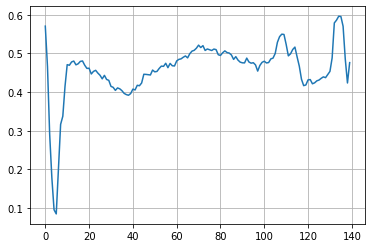

In [ ]:
# Download ECG dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values # extract data

labels = raw_data[:, -1] # extract labels
data = raw_data[:, 0:-1] # extract data

# Create train-test split (80-20)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalise data w.r.t train data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# Example of what a data point looks like
plt.grid()
plt.plot(np.arange(140), train_data[0])
plt.show()

In [ ]:
# Create similar, but for whole dataset.
# Normalised and labels one-hot encoded
label_fix = OneHotEncoder(sparse=False)

cv_data = data
cv_labels = labels
#normalise
cv_data = (cv_data - tf.reduce_min(cv_data)) / (tf.reduce_max(cv_data) - tf.reduce_min(cv_data))
cv_data = tf.cast(cv_data, tf.float32)
#one hot encode
cv_labels = np.float32(label_fix.fit_transform(cv_labels.reshape(-1,1)))

# Encoding labels

In [ ]:
#
# Encode labels in one-hot notation
#
train_labels = label_fix.fit_transform(train_labels.reshape(-1,1))
test_labels = label_fix.fit_transform(test_labels.reshape(-1,1))
train_labels = train_labels.astype(np.int)
test_labels = test_labels.astype(np.int)

# Download MIT ECG Dataset (for comparison)

**Using mitbih_test data from https://www.kaggle.com/shayanfazeli/heartbeat -- stored as my own private Github gist**

In [ ]:
mit_dataframe = pd.read_csv('https://gist.githubusercontent.com/davej23/3add6482c679a578c5dcc13f323debf3/raw/3f04ebc47efa1d233fc30328597ad7b531c0cc8e/mitbih_test.csv', header=None)
mit_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.998141,0.921933,0.325279,0.000000,0.185874,0.278810,0.278810,0.289963,0.282528,0.286245,0.295539,0.288104,0.276952,0.284387,0.293680,0.291822,0.286245,0.291822,0.295539,0.286245,0.288104,0.295539,0.306691,0.302974,0.299257,0.308550,0.317844,0.319703,0.323420,0.332714,0.347584,0.356877,0.360595,0.379182,0.407063,0.416357,0.421933,0.447955,0.464684,0.466543,...,0.338290,0.566914,0.866171,1.000000,0.557621,0.050186,0.026022,0.167286,0.197026,0.247212,0.280669,0.260223,0.260223,0.275093,0.284387,0.271375,0.267658,0.276952,0.284387,0.273234,0.275093,0.278810,0.284387,0.282528,0.278810,0.286245,0.295539,0.293680,0.291822,0.289963,0.315985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.058036,0.187500,0.265625,0.377232,0.484375,0.618304,0.683036,0.685268,0.725446,0.765625,0.761161,0.725446,0.714286,0.758929,0.792411,0.792411,0.776786,0.810268,0.785714,0.832589,0.830357,0.841518,0.837054,0.870536,0.908482,0.910714,0.848214,0.924107,0.930804,1.000000,0.895089,0.883929,0.919643,0.966518,0.921875,0.928571,0.912946,0.921875,0.875000,0.881696,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.972625,0.887279,0.314010,0.000000,0.161031,0.247987,0.260870,0.281804,0.293076,0.294686,0.285024,0.286634,0.293076,0.297907,0.288245,0.286634,0.293076,0.297907,0.289855,0.278583,0.294686,0.301127,0.297907,0.294686,0.305958,0.312399,0.309179,0.307568,0.326892,0.336554,0.338164,0.354267,0.371981,0.389694,0.402576,0.412238,0.431562,0.446055,0.446055,0.438003,...,0.925926,1.000000,0.524960,0.069243,0.162641,0.289855,0.270531,0.281804,0.304348,0.299517,0.288245,0.288245,0.301127,0.301127,0.296296,0.289855,0.297907,0.305958,0.294686,0.293076,0.301127,0.304348,0.302738,0.299517,0.304348,0.320451,0.314010,0.320451,0.330113,0.339775,0.346216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.053731,0.247761,0.426866,0.522388,0.561194,0.570149,0.582090,0.582090,0.591045,0.600000,0.611940,0.602985,0.602985,0.632836,0.641791,0.635821,0.629851,0.644776,0.659701,0.665672,0.668657,0.686567,0.695522,0.710448,0.722388,0.746269,0.785075,0.794030,0.805970,0.853731,0.898507,0.907463,0.922388,0.955224,0.976119,0.973134,0.946269,0.943284,0.907463,0.847761,...,0.319403,0.471642,0.540299,0.543284,0.531343,0.555224,0.579104,0.573134,0.573134,0.591045,0.605970,0.605970,0.594030,0.608955,0.626866,0.626866,0.614925,0.641791,0.653731,0.656716,0.677612,0.701493,0.734328,0.737313,0.770149,0.808955,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.953789,0.866913,0.545287,0.168207,0.245841,0.299445,0.297597,0.314233,0.330869,0.304991,0.293900,0.303142,0.306839,0.304991,0.299445,0.277264,0.282810,0.269871,0.253235,0.238447,0.269871,0.271719,0.260628,0.232902,0.227357,0.221811,0.188540,0.168207,0.146026,0.112754,0.088725,0.042514,0.014787,0.000000,0.001848,0.001848,0.020333,0.044362,0.086876,0.131238,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mit_dataframe.shape

(10000, 188)

In [ ]:
# Remove label 4 as unknown type
mit_dataframe = mit_dataframe[mit_dataframe[187] != 4.0]

In [ ]:
mit_raw_data = mit_dataframe.values
mit_labels_raw = mit_raw_data[:,-1] # extract labels from final column
mit_data = mit_raw_data[:,0:-1] # extract data

# change labels 1,2,3 to be 0 (3 classes of abnormalities, to a single one)
for i in range(len(mit_labels_raw)):
  if mit_labels_raw[i] in [1.0,2.0,3.0]:
    mit_labels_raw[i] = 0
  else: # if normal (0), assign label 1 (MIT and our dataset have different meanings)
    mit_labels_raw[i] = 1

#
# Remove data which have more than 50 zeros (padding)
# Allows this data to be tested with our trained classifiers
#
mit_new = [] # new data set
mit_new_labels = [] # new labels

for i in range(len(mit_data)): 
  # create new data set where each point has less than 50 zeros
  # some zeros within normal vector, but not many, so this should be a good enough method
  if np.sum(mit_data[i] == 0) < 50:
    mit_new.append(mit_data[i])
    mit_new_labels.append(mit_labels_raw[i])

# create np array
mit_new = np.array(mit_new)
mit_new_labels = np.array(mit_new_labels)

# Reduce size of each observation to 140
mit_new = mit_new[:,0:140]

print(mit_new.shape)
print(mit_new_labels.shape)

# Set mit_data as new smaller data set
mit_data = mit_new
mit_labels_raw = mit_new_labels

# Normalise data w.r.t train data
mit_data = (mit_data - np.min(mit_data)) / ((np.max(mit_data) - np.min(mit_data)))


# OneHot encode labels
mit_labels = []
mit_labels = label_fix.fit_transform(mit_labels_raw.reshape(-1,1))
mit_labels = mit_labels.astype(np.int)
mit_labels = np.array(mit_labels)

# Create train-test split
mit_train_data, mit_test_data, mit_train_labels, mit_test_labels = train_test_split(mit_data, mit_labels, test_size=0.2, random_state=123)

mit_train_data = tf.cast(mit_train_data, tf.float32)
mit_test_data = tf.cast(mit_test_data, tf.float32)
mit_data = tf.cast(mit_data, tf.float32)

(1501, 140)
(1501,)


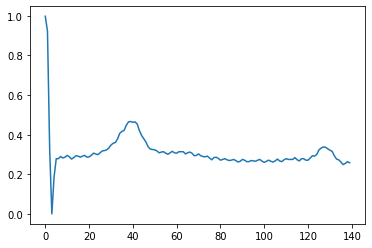

In [ ]:
# Example of one MIT data point
plt.plot(mit_data[0])

# Functions

In [ ]:
#
# These are 'from scratch' versions of the scoring metrics used from the scikit-learn package, if needed
#

'''
def confusion(predicted, expected): # compute confusion matrix (2d specifically for our datasets)
  if type(predicted) == list: # if list input, create an array
    predicted = np.array(predicted)
  if type(expected) == list:
    expected = np.array(expected)

  predicted = np.argmax(predicted, axis=1)
  expected = np.argmax(expected, axis=1)    

  # create empty matrix
  out = np.zeros((2,2))

  # for every predicted output, place in correct place in matrix
  for i in range(len(predicted)):
      out[predicted[i]][expected[i]] += 1

  return out

def precision_score(predicted, expected): # find WEIGHTED precision score
  confmat = confusion(predicted, expected)  
  precs = [0,0]

  for i in range(len(confmat)):
    a = confmat[i][i]
    b = sum(confmat[:,i]) - a
    precs[i] = (a/(a+b))*sum(confmat[i])

  prec = sum(precs)/sum(sum(confmat)) # dividing by total number of points, for final weighted result

  return prec

def f1_score(predicted, expected): # find f-score by calling precision and recall
  prec = precision_score(predicted, expected)
  rec = recall_score(predicted, expected)
  return 2 * prec * rec / (prec+rec)

def recall_score(predicted, expected): # find WEIGHTED recall score of predicted vs expected
  confmat = confusion(predicted, expected) # compute confusion matrix
  predicted = np.argmax(predicted, axis=1)
  expected = np.argmax(expected, axis=1)

  if len(np.unique(predicted)) == 1:
    return 0

  recs = [0,0]

  for i in range(len(confmat)):
    a = confmat[i][i]
    b = sum(confmat[i])-a
    recs[i] = (a / (a+b))*sum(confmat[i])

  rec = sum(recs) / sum(sum(confmat)) # dividing by total number of points for final weighted result

  return rec

def accuracy_score(predicted, expected): # find accuracy of predictions vs expected
  predicted = np.argmax(predicted, axis=1) # create 1d vector from 2d (reverse one-hot)
  expected = np.argmax(expected, axis=1)

  correct = 0
  total = len(expected)

  for i in range(len(predicted)):
    if predicted[i] == expected[i]:
      correct += 1


  return correct/total
'''

'\ndef confusion(predicted, expected): # compute confusion matrix (2d specifically for our datasets)\n  if type(predicted) == list: # if list input, create an array\n    predicted = np.array(predicted)\n  if type(expected) == list:\n    expected = np.array(expected)\n\n  predicted = np.argmax(predicted, axis=1)\n  expected = np.argmax(expected, axis=1)    \n\n  # create empty matrix\n  out = np.zeros((2,2))\n\n  # for every predicted output, place in correct place in matrix\n  for i in range(len(predicted)):\n      out[predicted[i]][expected[i]] += 1\n\n  return out\n\ndef precision_score(predicted, expected): # find WEIGHTED precision score\n  confmat = confusion(predicted, expected)  \n  precs = [0,0]\n\n  for i in range(len(confmat)):\n    a = confmat[i][i]\n    b = sum(confmat[:,i]) - a\n    precs[i] = (a/(a+b))*sum(confmat[i])\n\n  prec = sum(precs)/sum(sum(confmat)) # dividing by total number of points, for final weighted result\n\n  return prec\n\ndef f1_score(predicted, expecte

In [ ]:
# Function to quickly create a train-test split with train_size=n
def train_test(train_size):
  train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size = train_size, random_state=21)

  # Normalise train and test data w.r.t train data min and max values
  min_val = tf.reduce_min(train_data)
  max_val = tf.reduce_max(train_data)

  train_data = (train_data - min_val) / (max_val - min_val)
  test_data = (test_data - min_val) / (max_val - min_val)

  # Create TF tensors
  train_data = tf.cast(train_data, tf.float32)
  test_data = tf.cast(test_data, tf.float32)

  # One-Hot encode labels
  label_fix = OneHotEncoder(sparse=False)
  train_labels = label_fix.fit_transform(train_labels.reshape(-1,1))
  test_labels = label_fix.fit_transform(test_labels.reshape(-1,1))
  train_labels = train_labels.astype(np.int)
  test_labels = test_labels.astype(np.int)


  return train_data, test_data, train_labels, test_labels

In [ ]:
cls = ['MLP', 'CNN', 'DAE', 'CNN-LSTM'] #list of classifiers for plotting
training_times = [] # hold training times for single train test split
metrics = [] # hold data from single train test split

# Single train/test with 80/20 split

### Multi-layer Perceptron (one hidden layer) (For a baseline) ###

In [ ]:
class MLP:
  def __init__(self, train_data, train_labels, hidden_layer=32, loss_fn='mse', optimizer='adam', epochs=10, batch_size=32):
    # initialise constructor with changeable labels
    self.train_data = train_data
    self.train_labels = train_labels
    self.hidden_layer = hidden_layer
    self.epochs = epochs
    self.batch_size = batch_size
    self.loss_fn = loss_fn
    self.optimizer = optimizer

    # Define our common structure (single hidden layer)
    self.mlp_model = Sequential()
    self.mlp_model.add(Dense(self.hidden_layer, input_shape=(self.train_data.shape[1],), activation='sigmoid'))
    self.mlp_model.add(Dense(len(np.unique(self.train_labels)), activation='softmax')) # output probability distribution for labels

    # Configure the model and start training
    self.mlp_model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])
    self.history = self.mlp_model.fit(self.train_data, self.train_labels, epochs=self.epochs, batch_size=self.batch_size, verbose=0, validation_split=0.1, shuffle=True)

  def perf(self, data, labels):
    # Test the model after training
    outputs = self.mlp_model.predict(data)
    outputs = np.round(outputs)
    # Return metrics for results
    return accuracy_score(outputs, labels), precision_score(outputs, labels, average='weighted'), recall_score(outputs, labels, average='weighted'), f1_score(outputs, labels, average='weighted')

# Time training of this model
start = timer()
mlp_model = MLP(train_data, train_labels)
end = timer()
training_times.append(end-start)
metrics.append(mlp_model.perf(test_data, test_labels)) # add the metrics to common vector for future analysis

print(mlp_model.perf(test_data, test_labels))

(0.974, 0.9741805194805194, 0.974, 0.9740270674734857)


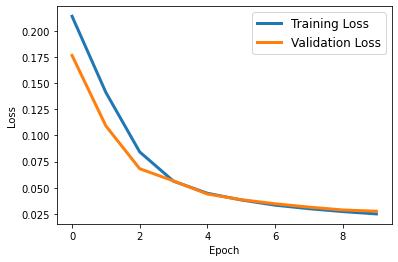

In [ ]:
# Plot training and validation loss

plt.plot(mlp_model.history.history['loss'], label="Training Loss", linewidth=3)
plt.plot(mlp_model.history.history['val_loss'], label="Validation Loss", linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(prop={'size': 12})


### Convolutional Neural Network ###

In [ ]:
class CNN:
  def __init__(self, train_data, train_labels, loss_fn='mse', optimizer='adam', epochs=10, batch_size=32):
    # define constructor with changeable parameters
    self.train_data = train_data
    self.train_labels = train_labels
    self.epochs = epochs
    self.batch_size = batch_size
    self.loss_fn = loss_fn
    self.optimizer = optimizer


    # Configure network (Conv1D, Pooling, Flatten, FCL, FCL, Output)
    self.cnn_model = Sequential()
    self.cnn_model.add(Conv1D(2, kernel_size=8, strides=2, padding='same', activation='relu', input_shape=(self.train_data.shape[1], 1)))
    self.cnn_model.add(MaxPooling1D(2))
    self.cnn_model.add(Flatten())
    self.cnn_model.add(Dense(32, activation='relu'))
    self.cnn_model.add(Dense(16, activation='relu'))
    self.cnn_model.add(Dense(len(np.unique(self.train_labels)), activation='softmax'))

    # Set parameters and start training
    self.cnn_model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])
    self.history = self.cnn_model.fit(self.train_data.numpy().reshape(self.train_data.shape[0], self.train_data.shape[1], 1), self.train_labels, epochs=self.epochs, batch_size=self.batch_size, shuffle=True, validation_split=0.1, verbose=0)

  def perf(self, data, labels):
    # Test the model after training
    outputs = np.round(self.cnn_model.predict(data.numpy().reshape(data.shape[0], data.shape[1], 1)))
    # Return metrics of results
    return accuracy_score(outputs, labels), precision_score(outputs, labels, average='weighted'), recall_score(outputs, labels, average='weighted'), f1_score(outputs, labels, average='weighted')

start = timer()
cnn_model = CNN(train_data, train_labels)
end = timer()
training_times.append(end-start)
metrics.append(cnn_model.perf(test_data, test_labels))

print(cnn_model.perf(test_data, test_labels))

(0.985, 0.9849983766233766, 0.985, 0.9849981893595202)


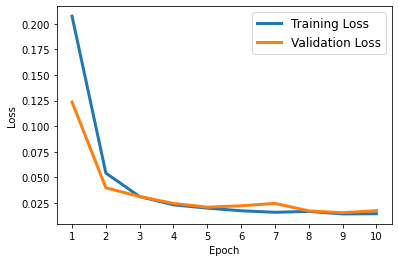

In [ ]:
# Plot training and validation loss
plt.plot(np.linspace(1,10,10), cnn_model.history.history['loss'], label="Training Loss", linewidth=3)
plt.plot(np.linspace(1,10,10), cnn_model.history.history['val_loss'], label="Validation Loss", linewidth=3)
plt.xlabel('Epoch')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylabel('Loss')
plt.legend(prop={'size': 12})

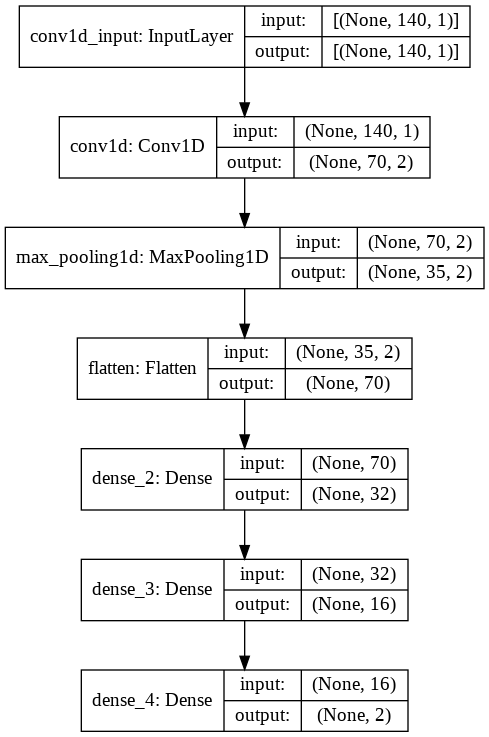

In [ ]:
plot_model(cnn_model.cnn_model, show_shapes=True)

### Deep Autoencoder ###

In [ ]:
###### https://www.tensorflow.org/tutorials/generative/autoencoder ######

In [ ]:
# Change single labels (0,1 etc) into booleans
# First need to retrieve 1d labels from our one-hot encoded labels

normal_train_labels = np.argmax(train_labels, axis=1).astype(bool)
normal_test_labels = np.argmax(test_labels, axis=1).astype(bool)

# Normal ECGs are those with label 1 (become TRUE when set as boolean values)
normal_train_data = train_data[normal_train_labels]
normal_test_data = test_data[normal_test_labels]

# Anomalous (abnormal) ECGs are those with label FALSE
anomalous_train_data = train_data[~normal_train_labels]
anomalous_test_data = test_data[~normal_test_labels]

In [ ]:
class DAE:
  def __init__(self, train_data, test_data, latent=64, epochs=10, batch_size=32, optimizer='adam', loss_fn='mse'):
    # initialise constructor and changeable parameters
    self.latent = latent # hidden layer in middle of network
    self.train_data = train_data
    self.test_data = test_data
    self.epochs = epochs
    self.batch_size = batch_size
    self.optimizer = optimizer
    self.loss_fn = loss_fn

    # configure network (2 FCLs, Latent Space, 2 FCLs, Output)
    self.dae_model = Sequential()
    self.dae_model.add(Dense(16, activation='relu'))
    self.dae_model.add(Dense(32, activation='relu'))
    self.dae_model.add(Dense(self.latent, activation='relu', input_shape=(self.train_data.shape[1],))) # latent space
    self.dae_model.add(Dense(32, activation='relu'))    
    self.dae_model.add(Dense(16, activation='relu'))
    self.dae_model.add(Dense(self.train_data.shape[1], activation='sigmoid'))

    # Configure network and train
    self.dae_model.compile(optimizer=self.optimizer, loss=self.loss_fn)
    self.history = self.dae_model.fit(self.train_data, self.train_data, epochs=self.epochs, batch_size=self.batch_size, validation_data=(self.test_data, self.test_data), shuffle=True, verbose=0)

  def perf(self, data, labels, standard_devs=3):
    # Find loss from reproducing normal ECGs after being trained on normal ECGs
    normal_reproduction_loss = tf.keras.losses.mse(self.dae_model.predict(self.train_data), self.train_data)
    
    # Find loss between reproduced images and original normal images
    self.error_threshold = np.mean(normal_reproduction_loss) + standard_devs*np.std(normal_reproduction_loss)

    # Reproduce test data and find loss between these and original test data
    test_reproduction = self.dae_model.predict(data)
    test_reproduction_loss = tf.keras.losses.mse(test_reproduction, data)

    predictions = []
    # if loss is greater than threshold from normal images, it is abnormal
    for i in range(len(test_reproduction_loss)):
      if np.mean(test_reproduction_loss[i]) > self.error_threshold:
        predictions.append([1,0])
      else:
        predictions.append([0,1])

    predictions = np.array(predictions)

    return accuracy_score(predictions, labels), precision_score(predictions, labels, average='weighted'), recall_score(predictions, labels, average='weighted'), f1_score(predictions, labels, average='weighted')


start = timer()
dae_model = DAE(normal_train_data, normal_test_data)
end = timer()
training_times.append(end-start)
metrics.append(dae_model.perf(test_data, test_labels))

print(dae_model.perf(test_data, test_labels))

(0.979, 0.9790029220779219, 0.979, 0.9789925266979685)


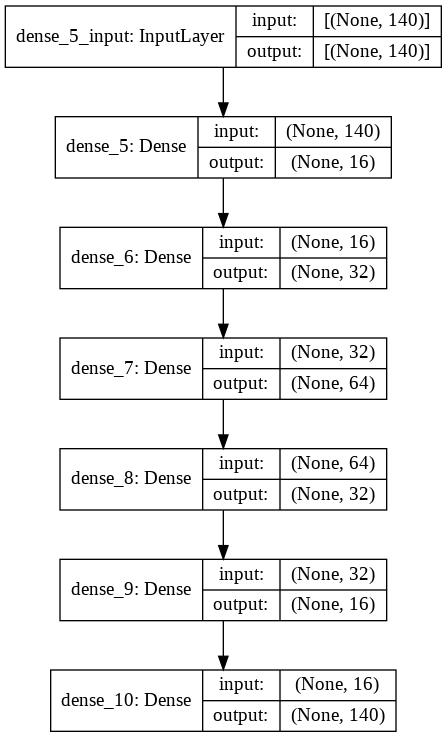

In [ ]:
plot_model(dae_model.dae_model, show_shapes=True)

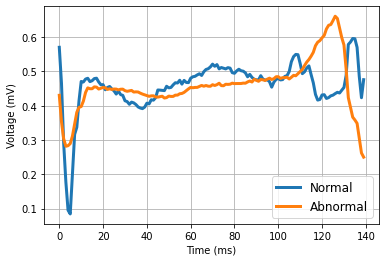

In [ ]:
#
# Create a plot of normal vs abnormal ECG
#

plt.grid()
plt.plot(np.arange(140), normal_train_data[0], linewidth=3)
plt.plot(np.arange(140), anomalous_train_data[0], linewidth=3)
plt.legend(['Normal', 'Abnormal'], prop={'size': 12})
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
plt.title("")
plt.show()

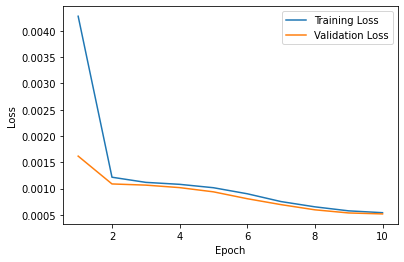

In [ ]:
# Plot training and validation losses
plt.plot(np.linspace(1,10,10), dae_model.history.history["loss"], label="Training Loss")
plt.plot(np.linspace(1,10,10), dae_model.history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

Text(0, 0.5, 'Voltage (mV)')

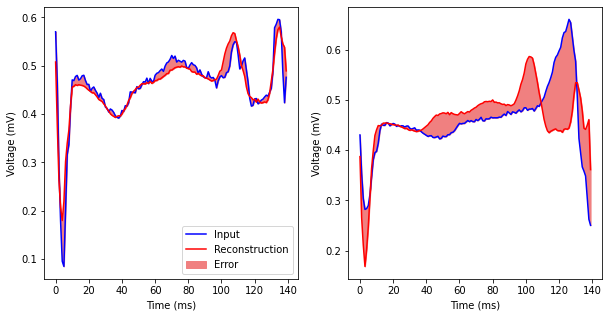

In [ ]:
# Encode a normal ECG, decode and find error in reconstruction
# Encode an abnormal ECG, decode and find error in reconstruction

normal_ecg_example = normal_train_data[0] # example data from normal ECGs
normal_ecg_example_reconstruction = dae_model.dae_model.predict(np.array([normal_ecg_example,]))[0] # construct reproduced image of above data point

abnormal_ecg_example = anomalous_train_data[0] # example anomalous ECG
abnormal_ecg_example_reconstruction = dae_model.dae_model.predict(np.array([abnormal_ecg_example,]))[0]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(normal_ecg_example,'b')
ax1.plot(normal_ecg_example_reconstruction,'r')
ax1.fill_between(np.arange(140), normal_ecg_example, normal_ecg_example_reconstruction, color='lightcoral' )
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax1.legend(labels=["Input", "Reconstruction", "Error"])

ax2.plot(abnormal_ecg_example,'b')
ax2.plot(abnormal_ecg_example_reconstruction,'r')
ax2.fill_between(np.arange(140), abnormal_ecg_example, abnormal_ecg_example_reconstruction, color='lightcoral' )
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Voltage (mV)')

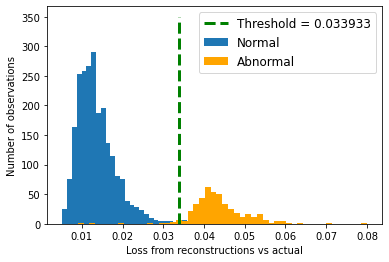

In [ ]:
# Find loss from reconstructing normal one vs loss from reconstructing abnormal one
normal_reconstructions = dae_model.dae_model.predict(normal_train_data) # reconstruct all normal ECGs
train_loss = tf.keras.losses.mae(normal_reconstructions, normal_train_data) # find loss between these and original normal ECGs

mean_loss = np.mean(train_loss)
loss_threshold = mean_loss + 3*np.std(train_loss) # threshold for classifying normal vs abnormal

abnormal_reconstructions = dae_model.dae_model.predict(anomalous_test_data) # construct anomalous images
test_loss = tf.keras.losses.mae(abnormal_reconstructions, anomalous_test_data) # find loss between these and original anomalous images

# create plotted line at threshold
p1 = [loss_threshold, loss_threshold]
p2 = [0, 350]

plt.hist(train_loss, bins=50, label='Normal')
plt.hist(test_loss, bins=50, color='orange', label='Abnormal')
plt.plot(p1, p2, '--', linewidth=3, label='Threshold = %f' % loss_threshold, color='green')
plt.xlabel("Loss from reconstructions vs actual")
plt.ylabel("Number of observations")
plt.legend(prop={'size': 12})
plt.show()

### CNN-LSTM ###

In [ ]:
###### https://machinelearningmastery.com/lstm-autoencoders/ ######

In [ ]:
'''
class CNN_LSTM:
  def __init__(self, train_data, train_labels, loss_fn='mse', optimizer='adam', epochs=10, batch_size=32):
    # define initial constructor and parameters
    self.train_data = train_data
    self.train_labels = train_labels
    self.epochs = epochs
    self.batch_size = batch_size
    self.loss_fn = loss_fn
    self.optimizer = optimizer

    # Defining network structure (1d convolution, pooling, lstm, FC layer, output)
    self.cnn_lstm_model = Sequential()
    self.cnn_lstm_model.add(Conv1D(16, 3, padding='same', activation='relu', input_shape=(self.train_data.shape[1],1)))
    self.cnn_lstm_model.add(MaxPooling1D(2))
    self.cnn_lstm_model.add(LSTM(32))
    self.cnn_lstm_model.add(Dense(8, activation='relu'))
    self.cnn_lstm_model.add(Dense(len(np.unique(self.train_labels)), activation='softmax'))

    # Set parameters and train
    self.cnn_lstm_model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])
    self.history = self.cnn_lstm_model.fit(self.train_data.numpy().reshape(self.train_data.shape[0], self.train_data.shape[1], 1), self.train_labels, epochs=self.epochs, batch_size=self.batch_size, shuffle=True, validation_split=0.1, verbose=0)

  def perf(self, data, labels):
    # Evaluate test score
    outputs = np.round(self.cnn_lstm_model.predict(data.numpy().reshape(data.shape[0], data.shape[1], 1)))
    return accuracy_score(outputs, labels), precision_score(outputs, labels, average='weighted'), recall_score(outputs, labels, average='weighted'), f1_score(outputs, labels, average='weighted')

start = timer()
cnn_lstm_model = CNN_LSTM(train_data, train_labels)
end = timer()
training_times.append(end-start)
metrics.append(cnn_lstm_model.perf(test_data, test_labels))

print(cnn_lstm_model.perf(test_data, test_labels))
'''

"\nclass CNN_LSTM:\n  def __init__(self, train_data, train_labels, loss_fn='mse', optimizer='adam', epochs=10, batch_size=32):\n    # define initial constructor and parameters\n    self.train_data = train_data\n    self.train_labels = train_labels\n    self.epochs = epochs\n    self.batch_size = batch_size\n    self.loss_fn = loss_fn\n    self.optimizer = optimizer\n\n    # Defining network structure (1d convolution, pooling, lstm, FC layer, output)\n    self.cnn_lstm_model = Sequential()\n    self.cnn_lstm_model.add(Conv1D(16, 3, padding='same', activation='relu', input_shape=(self.train_data.shape[1],1)))\n    self.cnn_lstm_model.add(MaxPooling1D(2))\n    self.cnn_lstm_model.add(LSTM(32))\n    self.cnn_lstm_model.add(Dense(8, activation='relu'))\n    self.cnn_lstm_model.add(Dense(len(np.unique(self.train_labels)), activation='softmax'))\n\n    # Set parameters and train\n    self.cnn_lstm_model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])\n    self.histo

In [ ]:
# Encodes images with LSTM, trains CNN with encoded images
class CNN_LSTM:
  def __init__(self, train_data, train_labels, loss_fn='mse', optimizer='adam', epochs=5, batch_size=128, latent=32):
    # define initial constructor and parameters
    self.train_data = train_data
    self.train_labels = train_labels
    self.epochs = epochs
    self.batch_size = batch_size
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.latent = latent

    self.train_data = self.train_data.numpy().reshape(self.train_data.shape[0],self.train_data.shape[1], 1) # reshape data for convlution layer

    # Alternate method (classifying based off reconstructions rather than encodings)
    self.input = Input(shape=(self.train_data.shape[1], 1)) # set input shape
    self.encoded_layer = LSTM(self.latent)(self.input) # LSTM layer (latent)
    self.decoded_layer = LSTM(1, return_sequences=True)(RepeatVector(self.train_data.shape[1])(self.encoded_layer)) #(takes this layer, outputs encoded data)
    self.cnn_lstm_model = Model(self.input, self.decoded_layer) # this is model for training
    self.cnn_lstm_model_encoder = Model(self.input, self.encoded_layer) # this model encodes data

    # Set parameters and train
    self.cnn_lstm_model.compile(loss=self.loss_fn, optimizer=self.optimizer, metrics=['accuracy'])
    self.history = self.cnn_lstm_model.fit(self.train_data, self.train_data, epochs=self.epochs, batch_size=self.batch_size, shuffle=True, validation_split=0.1, verbose=0)

    self.reproduced = tf.cast(self.cnn_lstm_model_encoder.predict(self.train_data), tf.float32) # create tensor
    self.generated = CNN(self.reproduced, self.train_labels, epochs=15) # train CNN

  
  def perf(self, data, labels):
        
    # Alternate method (classifying based off reconstructions rather than encodings)
    # encode images, then call perf method from encoded image-trained CNN
    reproduced_test = tf.cast(self.cnn_lstm_model_encoder.predict(data), tf.float32)
    return self.generated.perf(reproduced_test, labels)

start = timer()
cnn_lstm_model = CNN_LSTM(train_data, train_labels)
end = timer()
print(end-start)
training_times.append(end-start)
metrics.append(cnn_lstm_model.perf(test_data, test_labels))

print(cnn_lstm_model.perf(test_data, test_labels))

26.477779697000017
(0.919, 0.9252839285714285, 0.919, 0.9197276790634957)


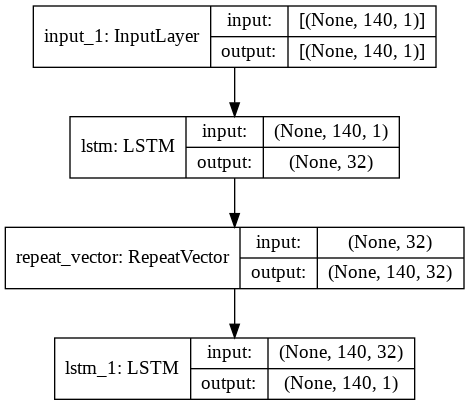

In [ ]:
plot_model(cnn_lstm_model.cnn_lstm_model, show_shapes=True)

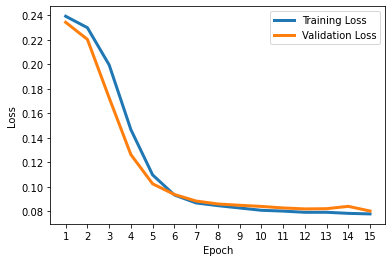

In [ ]:
#
# Plot training and validation losses
#

#plt.plot(cnn_lstm_model.history.history["loss"], label="Training Loss", linewidth=3)
#plt.plot(cnn_lstm_model.history.history["val_loss"], label="Validation Loss", linewidth=3)
#plt.legend()


plt.plot(np.linspace(1,15,15), cnn_lstm_model.generated.history.history["loss"], label="Training Loss", linewidth=3)
plt.plot(np.linspace(1,15,15), cnn_lstm_model.generated.history.history["val_loss"], label="Validation Loss", linewidth=3)
plt.xticks(np.linspace(1,15,15))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Metrics ###

In [ ]:
metrics = np.array(metrics)

In [ ]:
metrics[:,3]

array([0.97402707, 0.98499819, 0.97899253, 0.91972768])

In [ ]:
metrics

array([[0.974     , 0.97418052, 0.974     , 0.97402707],
       [0.985     , 0.98499838, 0.985     , 0.98499819],
       [0.979     , 0.97900292, 0.979     , 0.97899253],
       [0.919     , 0.92528393, 0.919     , 0.91972768]])

# Training and testing on MIT data

In [ ]:
mit_accs = [] # hold accuracy data from testing
mit_precs = [] # hold precision data from testing
mit_recs = [] # hold recall data from testing
mit_fscores = [] # hold fscore data from testing

# convert labels to booleans
normal_mit_train_labels = np.argmax(mit_train_labels, axis=1).astype(bool)
normal_mit_test_labels = np.argmax(mit_test_labels, axis=1).astype(bool)

# find normal ECGs and abnormal ECGs and split them
normal_mit_train_data = mit_train_data[normal_mit_train_labels]
normal_mit_test_data = mit_test_data[normal_mit_test_labels]
anomalous_mit_train_data = mit_train_data[~normal_mit_train_labels]
anomalous_mit_test_data = mit_test_data[~normal_mit_test_labels]


# Train and test on MLP
mit_mlp = MLP(mit_train_data, mit_train_labels)
a,b,c,w = mit_mlp.perf(mit_test_data, mit_test_labels)

# Train and test on CNN
mit_cnn = CNN(mit_train_data, mit_train_labels)
d,e,f,x = mit_cnn.perf(mit_test_data, mit_test_labels)

# Train and test on DAE
mit_dae = DAE(normal_mit_train_data, normal_mit_test_data)
g,h,i,y = mit_dae.perf(mit_test_data, mit_test_labels)

# Train and test on CNN-LSTM
mit_cnn_lstm = CNN_LSTM(mit_train_data, mit_train_labels)
j,k,l,z = mit_cnn_lstm.perf(mit_test_data, mit_test_labels)

# Output these results to appropriate arrays
mit_accs = np.array([a,d,g,j])
mit_precs = np.array([b,e,h,k])
mit_recs = np.array([c,f,i,l])
mit_fscores = np.array([w,x,y,z])

mit_accs

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.75747508, 0.90697674, 0.68106312, 0.67774086])

In [ ]:
#
# Print F-scores
#
mit_fscores

array([0.78545155, 0.91014947, 0.79555521, 0.80792079])

In [ ]:
#
# Print precision
#
mit_precs

array([0.85027269, 0.92211394, 0.97426139, 1.        ])

In [ ]:
#
# Print recall
#
mit_recs

array([0.75747508, 0.90697674, 0.68106312, 0.67774086])

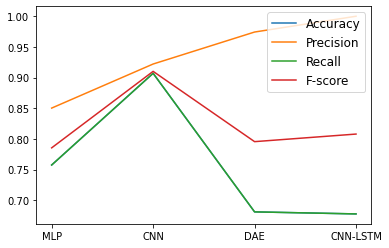

In [ ]:
#
# Plot metrics for MIT data
#

cls = ['MLP', 'CNN', 'DAE', 'CNN-LSTM']
plt.plot(cls, mit_accs, label='Accuracy')
plt.plot(cls, mit_precs, label='Precision')
plt.plot(cls, mit_recs, label='Recall')
plt.plot(cls, mit_fscores, label='F-score')
plt.legend(prop={'size':12})

Text(0, 0.5, 'Voltage (mV)')

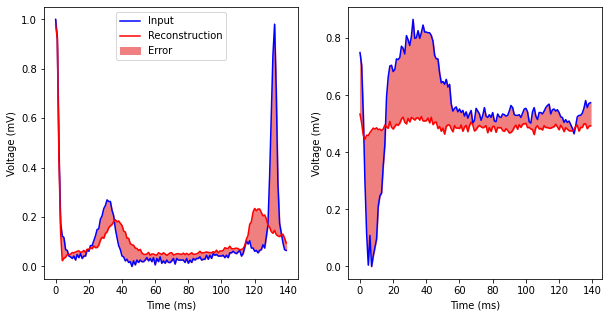

In [ ]:
#
# Find reconstruction error for MIT data, to compare with original dataset
#

# Encode a normal ECG, decode and find error in reconstruction
# Encode an abnormal ECG, decode and find error in reconstruction

normal_ecg_example = normal_mit_train_data[0]
normal_ecg_example_reconstruction = mit_dae.dae_model.predict(np.array([normal_ecg_example,]))[0]

abnormal_ecg_example = anomalous_mit_train_data[0]
abnormal_ecg_example_reconstruction = mit_dae.dae_model.predict(np.array([abnormal_ecg_example,]))[0]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(normal_ecg_example,'b')
ax1.plot(normal_ecg_example_reconstruction,'r')
ax1.fill_between(np.arange(140), normal_ecg_example, normal_ecg_example_reconstruction, color='lightcoral' )
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (mV)')
ax1.legend(labels=["Input", "Reconstruction", "Error"])

ax2.plot(abnormal_ecg_example,'b')
ax2.plot(abnormal_ecg_example_reconstruction,'r')
ax2.fill_between(np.arange(140), abnormal_ecg_example, abnormal_ecg_example_reconstruction, color='lightcoral' )
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Voltage (mV)')

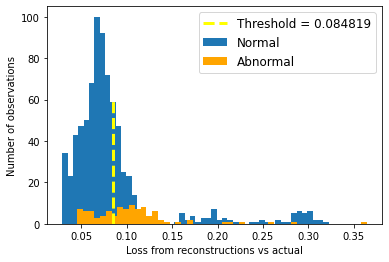

In [ ]:
# Find loss from reconstructing normal one vs loss from reconstructing abnormal one
normal_reconstructions = mit_dae.dae_model.predict(normal_mit_train_data)
train_loss = tf.keras.losses.mae(normal_reconstructions, normal_mit_train_data)

mean_loss = np.mean(train_loss)
loss_threshold = mean_loss# + 3*np.std(train_loss) # since there is greater overlap, use a lower offset

abnormal_reconstructions = mit_dae.dae_model.predict(anomalous_mit_test_data)
test_loss = tf.keras.losses.mae(abnormal_reconstructions, anomalous_mit_test_data)

# create plotted line at threshold
p1 = [loss_threshold, loss_threshold]
p2 = [0, 60]

plt.hist(train_loss, bins=50, label='Normal')
plt.hist(test_loss, bins=50, color='orange', label='Abnormal')
plt.plot(p1, p2, '--', linewidth=3, label='Threshold = %f' % loss_threshold, color='yellow')
plt.xlabel("Loss from reconstructions vs actual")
plt.ylabel("Number of observations")
plt.legend(prop={'size': 12})
plt.show()

In [ ]:
#
# Testing original classifiers on MIT data
#
print(MLP(train_data, train_labels).perf(mit_data, mit_labels))
print(CNN(train_data, train_labels).perf(mit_data, mit_labels))
print(DAE(normal_train_data, normal_test_data).perf(mit_data, mit_labels, standard_devs=6))
print(CNN_LSTM(train_data, train_labels).perf(mit_data, mit_labels))

(0.4170552964690207, 0.7933981195920046, 0.4170552964690207, 0.47894255035296507)
(0.4596935376415723, 0.760695429055441, 0.4596935376415723, 0.4975222988106705)
(0.3431045969353764, 0.9993344524791644, 0.3431045969353764, 0.5100883015834783)
(0.4183877415056629, 0.6059810794422689, 0.4183877415056629, 0.43725147108016854)


In [ ]:
# Poor results expected due to some padding remaining in ECG observations within MIT data
# This causes a sudden drop at end of ECG so large error
# Since labels 1,2,3,4 may be subtle difference to abnormal, wont be the same
# However, CNN-LSTM remains better than random

In [ ]:
#
# Testing original classifiers on MIT data (ONLY LABEL 0)
# As label 0 is abnormal data
#

print(MLP(train_data, train_labels).perf(mit_data[mit_labels_raw == 0], mit_labels[mit_labels_raw == 0]))
print(CNN(train_data, train_labels).perf(mit_data[mit_labels_raw == 0], mit_labels[mit_labels_raw == 0]))
print(DAE(normal_train_data, normal_test_data).perf(mit_data[mit_labels_raw == 0], mit_labels[mit_labels_raw == 0]))
print(CNN_LSTM(train_data, train_labels).perf(mit_data[mit_labels_raw == 0], mit_labels[mit_labels_raw == 0]))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9085603112840467, 0.8254818392405638, 0.9085603112840467, 0.8650309181848111)
(0.943579766536965, 0.8903427758179534, 0.943579766536965, 0.9161885621029591)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


(1.0, 1.0, 1.0, 1.0)
(0.754863813229572, 0.5698193765234901, 0.754863813229572, 0.649417205173113)


In [ ]:
print('Proportion of normal ECGs in MIT data:', len(mit_labels[np.argmax(mit_labels, axis=1) == 1])/len(mit_labels))
print('Proportion of abnormal ECGs in MIT data:', len(mit_labels[np.argmax(mit_labels, axis=1) == 0])/len(mit_labels))

Proportion of normal ECGs in MIT data: 0.6575616255829447
Proportion of abnormal ECGs in MIT data: 0.34243837441705527


# PCA

In [ ]:
pca_range = [5,10,20,40,80] # define PCA n_components we will use

def pcaEvaluate(): # function for evaluating different PCA components

  pca_metrics = [] # hold metrics of testing results
  pca_times = [] # hold times
  mlp_pca_loss = [] # hold training loss for mlp
  #mlp_pca_accu = []
  cnn_pca_loss = [] # hold training loss for cnn
  #cnn_pca_accu = []
  dae_pca_loss = [] # hold training loss for dae
  #dae_pca_accu = []
  cnn_lstm_pca_loss = [] # hold training loss for cnn-lstm
  #cnn_lstm_pca_accu = []

  for n in pca_range: # for each number of components
    pca_iter_times = []

    # transform original train and test data sets to new number of components
    train_data_pca = PCA(n_components=n).fit_transform(train_data)
    test_data_pca = PCA(n_components=n).fit_transform(test_data)

    # make them tensor type
    train_data_pca = tf.cast(train_data_pca, tf.float32)
    test_data_pca = tf.cast(test_data_pca, tf.float32)

    # Train MLP
    start = timer()
    mlp_pca_model = MLP(train_data_pca, train_labels)
    end = timer()
    pca_iter_times.append(end-start)
    a = (mlp_pca_model.perf(test_data_pca, test_labels))

    # Train CNN
    start = timer()
    cnn_pca_model = CNN(train_data_pca, train_labels)
    end = timer()
    pca_iter_times.append(end-start)
    b = (cnn_pca_model.perf(test_data_pca, test_labels))

    # Train DAE

    # First need to find normal and abnormal examples
    normal_train_labels = np.argmax(train_labels, axis=1).astype(bool)
    normal_test_labels = np.argmax(test_labels, axis=1).astype(bool)
    normal_train_data_pca = train_data_pca[normal_train_labels]
    normal_test_data_pca = test_data_pca[normal_test_labels]
    anomalous_train_data_pca = train_data_pca[~normal_train_labels]
    anomalous_test_data_pca = test_data_pca[~normal_test_labels]

    start = timer()
    dae_pca_model = DAE(normal_train_data_pca, normal_test_data_pca)
    end = timer()
    pca_iter_times.append(end-start)
    c = (dae_pca_model.perf(test_data_pca, test_labels))

    # Train CNN-LSTM
    start = timer()
    cnn_lstm_pca_model = CNN_LSTM(train_data_pca, train_labels)
    end = timer()
    pca_iter_times.append(end-start)
    d = (cnn_lstm_pca_model.perf(test_data_pca, test_labels))

    # append results to metric vector
    pca_metrics.append([a,b,c,d])
    pca_times.append(pca_iter_times)

    # append losses to appropriate vector
    mlp_pca_loss.append(mlp_pca_model.history.history['loss'])
    #mlp_pca_accu.append(mlp_pca_model.history.history['accuracy'])
    cnn_pca_loss.append(cnn_pca_model.history.history['loss'])
    #cnn_pca_accu.append(cnn_pca_model.history.history['accuracy'])
    dae_pca_loss.append(dae_pca_model.history.history['loss'])
    #dae_pca_accu.append(dae_pca_model.history.history['accuracy'])
    cnn_lstm_pca_loss.append(cnn_lstm_pca_model.history.history['loss'])
    #cnn_lstm_pca_accu.append(cnn_lstm_pca_model.history.history['accuracy'])

  return pca_metrics, pca_times, mlp_pca_loss, cnn_pca_loss, dae_pca_loss, cnn_lstm_pca_loss

pca_metrics, pca_times, mlp_pca_loss, cnn_pca_loss, dae_pca_loss, cnn_lstm_pca_loss = pcaEvaluate()
pca_metrics = np.array(pca_metrics)
pca_times = np.array(pca_times)
print(pca_metrics)
print(pca_times)

[[[0.874      0.88108247 0.874      0.8751613 ]
  [0.889      0.88986201 0.889      0.88922895]
  [0.711      0.86986737 0.711      0.74511497]
  [0.922      0.93582727 0.922      0.92325379]]

 [[0.874      0.88060714 0.874      0.87510287]
  [0.881      0.88228312 0.881      0.88132047]
  [0.707      0.85936429 0.707      0.74009178]
  [0.957      0.95783263 0.957      0.95690316]]

 [[0.873      0.87893604 0.873      0.87402542]
  [0.882      0.89102922 0.882      0.88331707]
  [0.626      0.90343961 0.626      0.70399361]
  [0.953      0.9535151  0.953      0.95290888]]

 [[0.876      0.88212468 0.876      0.87702898]
  [0.877      0.87987857 0.877      0.8775892 ]
  [0.605      0.90730357 0.605      0.69532733]
  [0.915      0.91547321 0.915      0.91512462]]

 [[0.875      0.88136364 0.875      0.87606556]
  [0.878      0.88243506 0.878      0.87880131]
  [0.669      0.86937013 0.669      0.71795373]
  [0.56       1.         0.56       0.71794872]]]
[[ 2.13950411  3.20152646  2.2

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#
# Find mean training time, F-score, precision and recall each n
#
for i in range(len(pca_metrics)):
  print('F-score',np.mean(pca_metrics[i][:,3]), np.std(pca_metrics[i][:,3]))
  print('Precision',np.mean(pca_metrics[i][:,1]), np.std(pca_metrics[i][:,1]))
  print('Recall',np.mean(pca_metrics[i][:,2]), np.std(pca_metrics[i][:,2]))
  print(np.mean(pca_times[i]), np.std(pca_times[i])) # print mean and std train time for each pca
  print('')

#
# Find mean train time and F-score overall
#

print('')
print(np.mean(training_times), np.std(training_times)) # mean and std training times
print(np.mean(metrics[:,3]), np.std(metrics[:,3])) # mean and std F-score
print(np.mean(metrics[:,1]), np.std(metrics[:,1])) # mean and std F-score
print(np.mean(metrics[:,2]), np.std(metrics[:,2])) # mean and std F-score

F-score 0.8581897512545448 0.06758457549702121
Precision 0.8941597808441557 0.02507881591177651
Recall 0.849 0.08154446639717501
4.525345696749994 3.4946961840184163

F-score 0.8633545695019242 0.07811185876853977
Precision 0.8950217938311689 0.037372165652088764
Recall 0.8547499999999999 0.09130272449385067
4.568000683000008 3.5262871864306704

F-score 0.8535612448982972 0.09157595470641892
Precision 0.9067299918831169 0.028366753167807866
Recall 0.8334999999999999 0.12374267655097815
5.116765818499999 4.4167801860618585

F-score 0.8412675313874219 0.08566148184202974
Precision 0.896195008116883 0.015485878914553958
Recall 0.81825 0.1241196499350526
5.759189419999984 5.486137919086592

F-score 0.797692330344959 0.07974697161782612
Precision 0.9082922077922078 0.05319536421841254
Recall 0.7455 0.13655493400093602
7.494268947249992 8.100318707695768


8.814393951250011 10.208046741959429
0.9644363656486176 0.02610324997233612
0.9658664366883116 0.023741642275772287
0.96425 0.02641377481

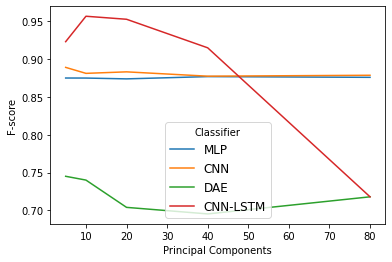

In [ ]:
#
# Plot accuracy for different number of components for each classifier
#
plt.plot(pca_range, [pca_metrics[i][:,3][0] for i in range(len(pca_metrics))], label='MLP')
plt.plot(pca_range, [pca_metrics[i][:,3][1] for i in range(len(pca_metrics))], label='CNN')
plt.plot(pca_range, [pca_metrics[i][:,3][2] for i in range(len(pca_metrics))], label='DAE')
plt.plot(pca_range, [pca_metrics[i][:,3][3] for i in range(len(pca_metrics))], label='CNN-LSTM')
plt.xlabel('Principal Components')
plt.ylabel('F-score')
plt.legend(title='Classifier', prop={'size':12})

# Cross-validation

In [ ]:
# Function to call an evaluation of cross-validation
def cvEvaluate():
  # Create five-fold split
  kfold_cross_validation = StratifiedKFold(n_splits = 5, shuffle=True)

  cv_data = data
  cv_labels = labels

  # Normalise data
  cv_data = (cv_data - tf.reduce_min(cv_data)) / (tf.reduce_max(cv_data) - tf.reduce_min(cv_data))
  #cv_data = tf.cast(cv_data, tf.float32)

  cv_metrics = [] # hold results

  for train_index, test_index in tqdm(kfold_cross_validation.split(cv_data, cv_labels)):
    # for each train-test split (of 5 total)
    # find new train and test data, and labels
    X_train, X_test = cv_data.numpy()[train_index], cv_data.numpy()[test_index]
    y_train, y_test = cv_labels[train_index], cv_labels[test_index]

    # create tensors and one-hot encode labels
    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = label_fix.fit_transform(y_train.reshape(-1,1))
    y_test = label_fix.fit_transform(y_test.reshape(-1,1))
    y_train = y_train.astype(np.int)
    y_test = y_test.astype(np.int)

    # find normal and abnormal data for DAE
    train_labels_cv = np.argmax(y_train, axis=1).astype(bool)
    test_labels_cv = np.argmax(y_test, axis=1).astype(bool)
    normal_train_data_cv = X_train[train_labels_cv]
    normal_test_data_cv = X_test[test_labels_cv]
    anomalous_train_data_cv = X_train[~train_labels_cv]
    anomalous_test_data_cv = X_test[~test_labels_cv]

    # Train MLP
    mlp_cv_model = MLP(X_train, y_train)
    a = mlp_cv_model.perf(X_test, y_test)

    # Train CNN
    cnn_cv_model = CNN(X_train, y_train)
    b = cnn_cv_model.perf(X_test, y_test)

    # Train DAE
    dae_cv_model = DAE(normal_train_data_cv, normal_test_data_cv)
    c = dae_cv_model.perf(X_test, y_test)

    # Train CNN-LSTM
    cnn_lstm_cv_model = CNN_LSTM(X_train, y_train)
    d = cnn_lstm_cv_model.perf(X_test, y_test)

    cv_metrics.append([a,b,c,d]) # append results to vector

  return cv_metrics # return all metrics


cv_metrics = cvEvaluate()
cv_metrics = np.array(cv_metrics)
cv_metrics

1it [00:38, 38.37s/it]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
5it [03:18, 39.74s/it]


array([[[0.963     , 0.96351413, 0.963     , 0.96309001],
        [0.972     , 0.97284108, 0.972     , 0.9720971 ],
        [0.964     , 0.964147  , 0.964     , 0.96393093],
        [0.912     , 0.92015806, 0.912     , 0.91316219]],

       [[0.964     , 0.96596207, 0.964     , 0.96420546],
        [0.584     , 1.        , 0.584     , 0.73737374],
        [0.976     , 0.97599974, 0.976     , 0.97598382],
        [0.925     , 0.92603563, 0.925     , 0.92524423]],

       [[0.962     , 0.96514028, 0.962     , 0.96229119],
        [0.984     , 0.98417597, 0.984     , 0.98402325],
        [0.965     , 0.96511196, 0.965     , 0.96503121],
        [0.892     , 0.91203128, 0.892     , 0.89468659]],

       [[0.97297297, 0.97408066, 0.97297297, 0.97308508],
        [0.98198198, 0.98204012, 0.98198198, 0.98199486],
        [0.96396396, 0.96396396, 0.96396396, 0.96396396],
        [0.92092092, 0.92085677, 0.92092092, 0.92088034]],

       [[0.96596597, 0.96653409, 0.96596597, 0.96605531],
      

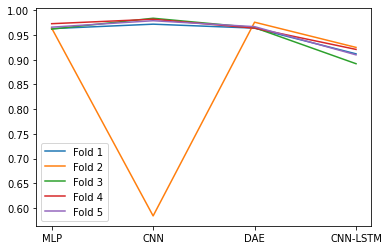

In [ ]:
#
# Plot cross-validation accuracy results
#

plt.plot(cls, cv_metrics[0][:,0], label='Fold 1')
plt.plot(cls, cv_metrics[1][:,0], label='Fold 2')
plt.plot(cls, cv_metrics[2][:,0], label='Fold 3')
plt.plot(cls, cv_metrics[3][:,0], label='Fold 4')
plt.plot(cls, cv_metrics[4][:,0], label='Fold 5')
plt.legend()

In [ ]:
#
# Find mean F-score for each classifier
#

print(np.mean([cv_metrics[i][:,3][0] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,3][0] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,3][1] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,3][1] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,3][2] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,3][2] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,3][3] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,3][3] for i in range(len(cv_metrics))]))
print('')
#
# Find mean precision for each classifier
#
'''
print(np.mean([cv_metrics[i][:,1][0] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,1][0] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,1][1] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,1][1] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,1][2] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,1][2] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,1][3] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,1][3] for i in range(len(cv_metrics))]))
print('')
'''
#
# Find mean recall for each classifier
#
'''
print(np.mean([cv_metrics[i][:,2][0] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,2][0] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,2][1] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,2][1] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,2][2] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,2][2] for i in range(len(cv_metrics))]))
print(np.mean([cv_metrics[i][:,2][3] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,2][3] for i in range(len(cv_metrics))]))
'''

0.9657454113939116 0.003881264074374783
0.9309021046793452 0.09684840296527682
0.9671742474778309 0.004540299195098552
0.9128707599671433 0.010528122691577787



'\nprint(np.mean([cv_metrics[i][:,2][0] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,2][0] for i in range(len(cv_metrics))]))\nprint(np.mean([cv_metrics[i][:,2][1] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,2][1] for i in range(len(cv_metrics))]))\nprint(np.mean([cv_metrics[i][:,2][2] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,2][2] for i in range(len(cv_metrics))]))\nprint(np.mean([cv_metrics[i][:,2][3] for i in range(len(cv_metrics))]), np.std([cv_metrics[i][:,2][3] for i in range(len(cv_metrics))]))\n'

# Changing learning rate



1.   Train set size = 0.8
2.   Epochs = 5
3.   Optimiser = Adam
4.   Loss fn = MSE
5.   Batch size = 32



In [ ]:
# Function to call evaluation learning rate alteration
def lrEvaluate():

  learning_rates = [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005]
  lr_metrics = []

  for n in learning_rates: # for each learning rate

    custom_lr_adam = tf.keras.optimizers.Adam(learning_rate=n) # create Adam optimizer object with set learning rate

    # Train each classifier and find performance on test data
    a = MLP(train_data, train_labels, optimizer=custom_lr_adam).perf(test_data, test_labels)

    b = CNN(train_data, train_labels, optimizer=custom_lr_adam).perf(test_data, test_labels)

    c = DAE(normal_train_data, normal_test_data, optimizer=custom_lr_adam).perf(test_data, test_labels)

    d = CNN_LSTM(train_data, train_labels, optimizer=custom_lr_adam).perf(test_data, test_labels)

    lr_metrics.append([a,b,c,d]) # save output metrics

  return lr_metrics


lr_metrics = np.array(lrEvaluate())
lr_metrics

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[[0.944     , 0.95065357, 0.944     , 0.9445426 ],
        [0.95      , 0.95168831, 0.95      , 0.95019393],
        [0.891     , 0.90718231, 0.891     , 0.89291548],
        [0.933     , 0.93745357, 0.933     , 0.93348242]],

       [[0.956     , 0.95933734, 0.956     , 0.95627094],
        [0.964     , 0.9643974 , 0.964     , 0.96405804],
        [0.959     , 0.95916932, 0.959     , 0.95903705],
        [0.923     , 0.92795292, 0.923     , 0.92358773]],

       [[0.96      , 0.96119643, 0.96      , 0.96012753],
        [0.987     , 0.98700519, 0.987     , 0.9870016 ],
        [0.957     , 0.9572586 , 0.957     , 0.95705077],
        [0.911     , 0.91135942, 0.911     , 0.91110508]],

       [[0.967     , 0.96846916, 0.967     , 0.96712219],
        [0.984     , 0.98400032, 0.984     , 0.98399617],
        [0.978     , 0.97804091, 0.978     , 0.97798475],
        [0.931     , 0.93759058, 0.931     , 0.93165218]],

       [[0.982     , 0.98199935, 0.982     , 0.98199569],
      

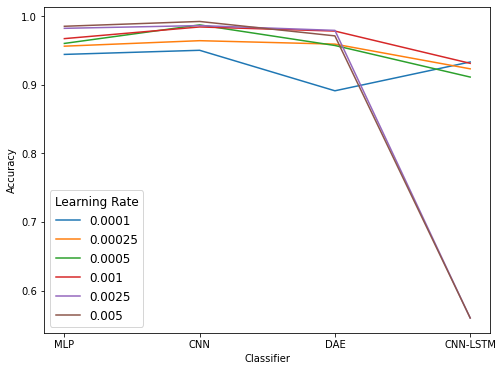

In [ ]:
#
# Plot accuracy for different learning rates
#

learning_rates = [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005]
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams.update({'font.size': 14})


ax.plot(cls, lr_metrics[0][:,0], label='0.0001')
ax.plot(cls, lr_metrics[1][:,0], label='0.00025')
ax.plot(cls, lr_metrics[2][:,0], label='0.0005')
ax.plot(cls, lr_metrics[3][:,0], label='0.001')
ax.plot(cls, lr_metrics[4][:,0], label='0.0025')
ax.plot(cls, lr_metrics[5][:,0], label='0.005')

ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy')
leg = ax.legend(loc='lower left', prop={'size':12})
leg.set_title('Learning Rate',prop={'size':12})

Text(0, 0.5, '1 - Mean F-score')

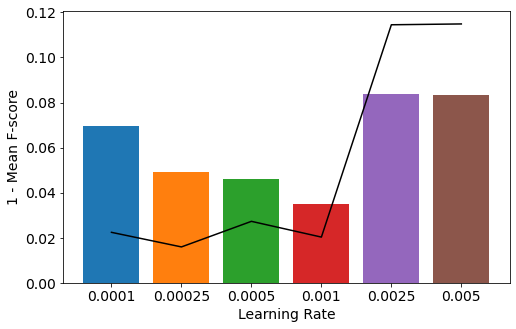

In [ ]:
#
# Plot mean f-score against learning rate (easier to visualise with 1-fscore)
#

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(0,1-np.mean(lr_metrics[0][:,3]), label='0.0001')
plt.bar(1,1-np.mean(lr_metrics[1][:,3]), label='0.00025')
plt.bar(2,1-np.mean(lr_metrics[2][:,3]), label='0.0005')
plt.bar(3,1-np.mean(lr_metrics[3][:,3]), label='0.001')
plt.bar(4,1-np.mean(lr_metrics[4][:,3]), label='0.0025')
plt.bar(5,1-np.mean(lr_metrics[5][:,3]), label='0.005')
plt.errorbar([0,1,2,3,4,5], [np.std(lr_metrics[i][:,3]) for i in range(len(lr_metrics))], color='black')
plt.xticks([0,1,2,3,4,5], learning_rates)
plt.xlabel('Learning Rate')
plt.ylabel('1 - Mean F-score')

In [ ]:
#
# Mean F-score for each LR (and standard dev)
#
print([np.mean(lr_metrics[i][:,3]) for i in range(len(lr_metrics))])
print([np.std(lr_metrics[i][:,3]) for i in range(len(lr_metrics))])
print('')
#
# Mean precision for each LR (and standard dev)
#
print([np.mean(lr_metrics[i][:,1]) for i in range(len(lr_metrics))])
print([np.std(lr_metrics[i][:,1]) for i in range(len(lr_metrics))])
print('')
#
# Mean recall for each LR (and standard dev)
#
print([np.mean(lr_metrics[i][:,2]) for i in range(len(lr_metrics))])
print([np.std(lr_metrics[i][:,2]) for i in range(len(lr_metrics))])

[0.9302836085105599, 0.9507384368260844, 0.9538212433355703, 0.9651888246928778, 0.916237877863932, 0.9164862933629704]
[0.022396147784708262, 0.0159220626777515, 0.027275473151527483, 0.020284825082063543, 0.11450940403146179, 0.11487553531378182]

[0.9367444399350648, 0.95271424512987, 0.9542049107142858, 0.9670252435064934, 0.9867898538961039, 0.9870648133116884]
[0.017966676930901124, 0.014449503542455265, 0.027247942368936334, 0.01787443920513999, 0.00803886670873564, 0.01062727521288502]

[0.9295, 0.9505, 0.95375, 0.9650000000000001, 0.87675, 0.877]
[0.023048861143232197, 0.016132265804901645, 0.027307279249313705, 0.020554804791094436, 0.18289255725698625, 0.18317614473506091]


# Changing epochs



1.   Train set size = 0.8 for all classifiers
2.   Optimiser = Adam for all classifiers
3.   Loss fn = MSE
4.   Batch size = 32
5.   LR = 0.001



In [ ]:
# Function to call evaluation of training for different number of epochs
def epochEvaluate():

  epochs = [1,3,5,10,15] # number of epochs we will be testing each classifier for
  epochs_metrics = []

  for n in epochs: # for each set number of epochs
    # Train all classifiers for epochs=n

    mlp_epoch_model = MLP(train_data, train_labels, epochs=n)
    a = mlp_epoch_model.perf(test_data, test_labels)

    cnn_epoch_model = CNN(train_data, train_labels, epochs=n)
    b = cnn_epoch_model.perf(test_data, test_labels)

    dae_epoch_model = DAE(normal_train_data, normal_test_data, epochs=n)
    c = dae_epoch_model.perf(test_data, test_labels)

    cnn_lstm_epoch_model = CNN_LSTM(train_data, train_labels, epochs=n)
    d = cnn_lstm_epoch_model.perf(test_data, test_labels)

    epochs_metrics.append([a,b,c,d])

  return epochs_metrics

epochs_metrics = epochEvaluate()
epochs_metrics = np.array(epochs_metrics)
epochs_metrics

array([[[0.904     , 0.9241276 , 0.904     , 0.90602382],
        [0.956     , 0.95901558, 0.956     , 0.95625327],
        [0.897     , 0.90778961, 0.897     , 0.89833725],
        [0.936     , 0.93987013, 0.936     , 0.93642036]],

       [[0.957     , 0.95876201, 0.957     , 0.95717444],
        [0.965     , 0.96670942, 0.965     , 0.96514198],
        [0.894     , 0.90905195, 0.894     , 0.89576667],
        [0.941     , 0.94575568, 0.941     , 0.94145034]],

       [[0.96      , 0.96119643, 0.96      , 0.96012753],
        [0.978     , 0.97817273, 0.978     , 0.9780229 ],
        [0.931     , 0.93407386, 0.931     , 0.93138354],
        [0.908     , 0.91419318, 0.908     , 0.90880527]],

       [[0.973     , 0.97342841, 0.973     , 0.97304752],
        [0.987     , 0.98719286, 0.987     , 0.98701535],
        [0.977     , 0.97702273, 0.977     , 0.9769866 ],
        [0.918     , 0.92102468, 0.918     , 0.91843978]],

       [[0.981     , 0.98107386, 0.981     , 0.98101206],
      

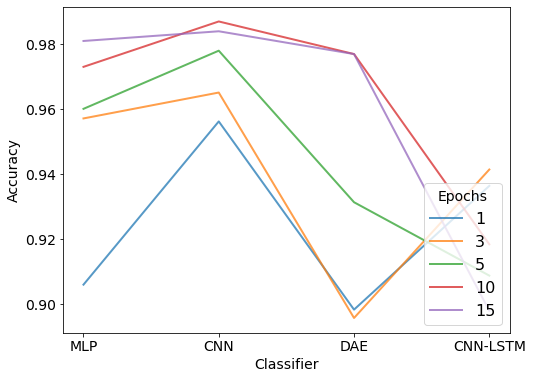

In [ ]:
#
# Plotting Fscore against epochs
#
epochs = [1,3,5,10,15]

#plt.plot(cls, ts_metrics[0][:,0], linewidth=2, alpha=.75, label='0.1')
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

ax.plot(cls, epochs_metrics[0][:,3], linewidth=2, alpha=.75, label='1')
ax.plot(cls, epochs_metrics[1][:,3], linewidth=2, alpha=.75, label='3')
ax.plot(cls, epochs_metrics[2][:,3], linewidth=2, alpha=.75, label='5')
ax.plot(cls, epochs_metrics[3][:,3], linewidth=2, alpha=.75, label='10')
ax.plot(cls, epochs_metrics[4][:,3], linewidth=2, alpha=.75, label='15')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifier')

leg = ax.legend(loc='lower right', prop={'size':16})
leg.set_title('Epochs',prop={'size':14})

Text(0, 0.5, '1 - Mean F-score')

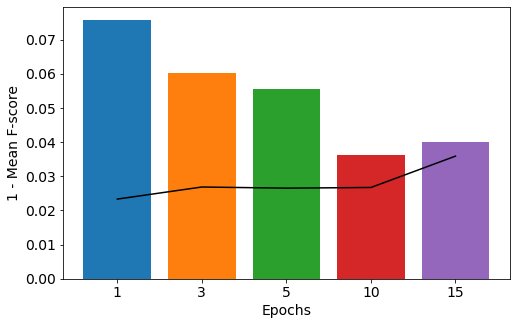

In [ ]:
#
# Plot mean f-score against number of epochs (easier to visualise with 1-fscore)
#

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(0,1-np.mean(epochs_metrics[0][:,3]), label='1')
plt.bar(1,1-np.mean(epochs_metrics[1][:,3]), label='3')
plt.bar(2,1-np.mean(epochs_metrics[2][:,3]), label='5')
plt.bar(3,1-np.mean(epochs_metrics[3][:,3]), label='10')
plt.bar(4,1-np.mean(epochs_metrics[4][:,3]), label='15')
plt.errorbar([0,1,2,3,4], [np.std(epochs_metrics[i][:,3]) for i in range(len(epochs_metrics))], color='black')
plt.xticks([0,1,2,3,4], epochs)
plt.xlabel('Epochs')
plt.ylabel('1 - Mean F-score')

In [ ]:
#
# Mean F-score for each N epoch (and standard dev)
#
print([np.mean(epochs_metrics[i][:,3]) for i in range(len(epochs_metrics))])
print([np.std(epochs_metrics[i][:,3]) for i in range(len(epochs_metrics))])
print('')
#
# Mean precision
#
print([np.mean(epochs_metrics[i][:,1]) for i in range(len(epochs_metrics))])
print([np.std(epochs_metrics[i][:,1]) for i in range(len(epochs_metrics))])
print('')
#
# Mean recall
#
print([np.mean(epochs_metrics[i][:,2]) for i in range(len(epochs_metrics))])
print([np.std(epochs_metrics[i][:,2]) for i in range(len(epochs_metrics))])
print('')

[0.9242586742105069, 0.9398833553891452, 0.9445848116754535, 0.963872312920194, 0.9599908375165027]
[0.023323758568852045, 0.02685943692175754, 0.02652419239003561, 0.02672023544215067, 0.035892121974387174]

[0.9327007305194804, 0.9450697646103896, 0.9469090503246753, 0.9646671672077922, 0.9615409496753247]
[0.01896005234820707, 0.022099240665339033, 0.024579548118994893, 0.025697728638302365, 0.03329559474747103]

[0.9232499999999999, 0.9392499999999999, 0.9442499999999999, 0.96375, 0.9597499999999999]
[0.023951774464536005, 0.027517040175135093, 0.026817671412708424, 0.026901440481877523, 0.036313737070150176]



# Changing training set size



1.   Epochs = 5 for all classifiers
2.   Optimiser = Adam for all classifiers
3.   Loss fn = MSE
4.   Batch size = 32
5.   LR = 0.001


In [ ]:
# UNNEEDED CODE (creates a copy of original data, if doing a more simple method of testing splits)
## Create copy of original entire data set that has been normalised
#ts_data = tf.cast((data - np.min(data)) / (np.max(data) - np.min(data)), tf.float32)
## One-hot encode entire original labels
#ts_labels = label_fix.fit_transform(np.array(labels).reshape(-1,1)).astype(np.int)
#ts_labels

In [ ]:
# Function to call evaluation of classifiers on different train set sizes
def trainSizeEvaluate():
  train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99] # train set proportions (sizes) we will be using
  ts_metrics = []

  for n in train_sizes: # for each train set size
    # Call train_test function which will create a split, normalise data and encode labels
    train_data, test_data, train_labels, test_labels = train_test(n)

    # find normal and abnormal labels for train and test data for DAE
    normal_train_labels_ts = np.argmax(train_labels, axis=1).astype(bool)
    normal_test_labels_ts = np.argmax(test_labels, axis=1).astype(bool)

    # train all classifiers
    mlp_ts_model = MLP(train_data, train_labels, epochs=5)
    a = mlp_ts_model.perf(test_data, test_labels)

    cnn_ts_model = CNN(train_data, train_labels, epochs=5)
    b = cnn_ts_model.perf(test_data, test_labels)

    dae_ts_model = DAE(train_data[normal_train_labels_ts], test_data[normal_test_labels_ts], epochs=5)
    c = dae_ts_model.perf(test_data, test_labels)

    cnn_lstm_ts_model = CNN_LSTM(train_data, train_labels, epochs=5)
    d = cnn_lstm_ts_model.perf(test_data, test_labels)

    ts_metrics.append([a,b,c,d])

  return ts_metrics

ts_metrics = trainSizeEvaluate()
ts_metrics = np.array(ts_metrics)
ts_metrics

array([[[0.70815737, 0.9124161 , 0.70815737, 0.75750102],
        [0.69170927, 0.91964064, 0.69170927, 0.74987808],
        [0.86508113, 0.89594062, 0.86508113, 0.86962273],
        [0.82107135, 0.88791615, 0.82107135, 0.83215958]],

       [[0.95348837, 0.95654001, 0.95348837, 0.95381899],
        [0.96574144, 0.96751264, 0.96574144, 0.96591911],
        [0.86346587, 0.8930115 , 0.86346587, 0.86781759],
        [0.89147287, 0.89875945, 0.89147287, 0.89271258]],

       [[0.95398466, 0.95678041, 0.95398466, 0.95429695],
        [0.96665555, 0.96721421, 0.96665555, 0.96674057],
        [0.87595865, 0.89829822, 0.87595865, 0.87919223],
        [0.9003001 , 0.90905414, 0.9003001 , 0.90163022]],

       [[0.9575    , 0.95892408, 0.9575    , 0.95767321],
        [0.973     , 0.97351239, 0.973     , 0.97306166],
        [0.896     , 0.90946698, 0.896     , 0.89777033],
        [0.923     , 0.93043446, 0.923     , 0.92388229]],

       [[0.965     , 0.96670942, 0.965     , 0.96514198],
      

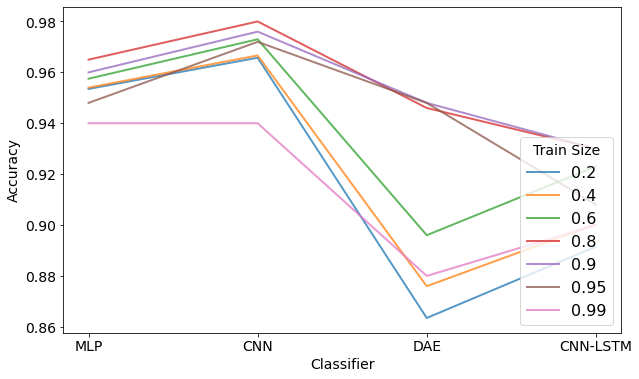

In [ ]:
#
# Plotting accuracy for different train set sizes 
#

train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]
plt.rcParams.update({'font.size': 14})

#plt.plot(cls, ts_metrics[0][:,0], linewidth=2, alpha=.75, label='0.1')
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cls, ts_metrics[1][:,0], linewidth=2, alpha=.75, label='0.2')
ax.plot(cls, ts_metrics[2][:,0], linewidth=2, alpha=.75, label='0.4')
ax.plot(cls, ts_metrics[3][:,0], linewidth=2, alpha=.75, label='0.6')
ax.plot(cls, ts_metrics[4][:,0], linewidth=2, alpha=.75, label='0.8')
ax.plot(cls, ts_metrics[5][:,0], linewidth=2, alpha=.75, label='0.9')
ax.plot(cls, ts_metrics[6][:,0], linewidth=2, alpha=.75, label='0.95')
ax.plot(cls, ts_metrics[7][:,0], linewidth=2, alpha=.75, label='0.99')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifier')
leg = ax.legend(loc='lower right', prop={'size':16})
leg.set_title('Train Size',prop={'size':14})

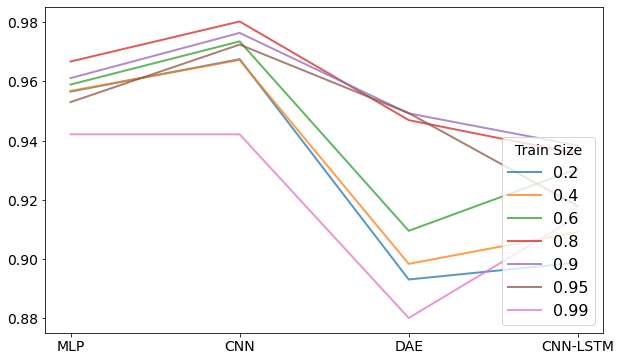

In [ ]:
#
# Plot precision against different train sizes
#

train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]

#plt.plot(cls, ts_metrics[0][:,0], linewidth=2, alpha=.75, label='0.1')
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cls, ts_metrics[1][:,1], linewidth=2, alpha=.75, label='0.2')
ax.plot(cls, ts_metrics[2][:,1], linewidth=2, alpha=.75, label='0.4')
ax.plot(cls, ts_metrics[3][:,1], linewidth=2, alpha=.75, label='0.6')
ax.plot(cls, ts_metrics[4][:,1], linewidth=2, alpha=.75, label='0.8')
ax.plot(cls, ts_metrics[5][:,1], linewidth=2, alpha=.75, label='0.9')
ax.plot(cls, ts_metrics[6][:,1], linewidth=2, alpha=.75, label='0.95')
ax.plot(cls, ts_metrics[7][:,1], linewidth=2, alpha=.75, label='0.99')
leg = ax.legend(loc='lower right', prop={'size':16})
leg.set_title('Train Size',prop={'size':14})

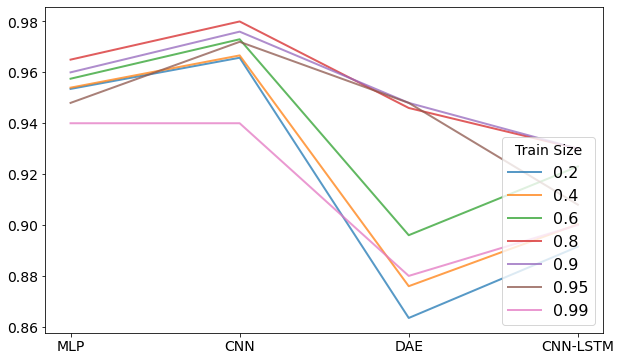

In [ ]:
#
# Plot recall against different train sizes
#

train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]

#plt.plot(cls, ts_metrics[0][:,0], linewidth=2, alpha=.75, label='0.1')
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cls, ts_metrics[1][:,2], linewidth=2, alpha=.75, label='0.2')
ax.plot(cls, ts_metrics[2][:,2], linewidth=2, alpha=.75, label='0.4')
ax.plot(cls, ts_metrics[3][:,2], linewidth=2, alpha=.75, label='0.6')
ax.plot(cls, ts_metrics[4][:,2], linewidth=2, alpha=.75, label='0.8')
ax.plot(cls, ts_metrics[5][:,2], linewidth=2, alpha=.75, label='0.9')
ax.plot(cls, ts_metrics[6][:,2], linewidth=2, alpha=.75, label='0.95')
ax.plot(cls, ts_metrics[7][:,2], linewidth=2, alpha=.75, label='0.99')
leg = ax.legend(loc='lower right', prop={'size':16})
leg.set_title('Train Size',prop={'size':14})

Text(0, 0.5, '1 - Mean F-score')

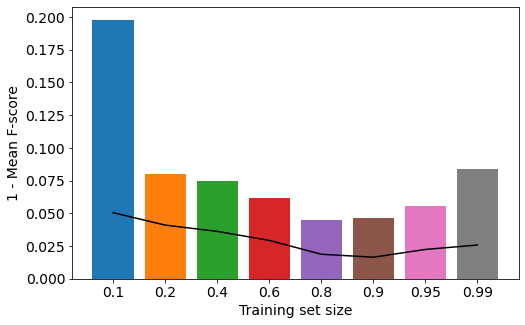

In [ ]:
#
# Plot mean f-score against train set size (easier to visualise with 1-fscore)
#
train_sizes = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]
plt.rcParams.update({'font.size': 14}) # increase size of x and y labels

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(0,1-np.mean(ts_metrics[0][:,3]), label='0.1')
plt.bar(1,1-np.mean(ts_metrics[1][:,3]), label='0.2')
plt.bar(2,1-np.mean(ts_metrics[2][:,3]), label='0.4')
plt.bar(3,1-np.mean(ts_metrics[3][:,3]), label='0.6')
plt.bar(4,1-np.mean(ts_metrics[4][:,3]), label='0.8')
plt.bar(5,1-np.mean(ts_metrics[5][:,3]), label='0.9')
plt.bar(6,1-np.mean(ts_metrics[6][:,3]), label='0.95')
plt.bar(7,1-np.mean(ts_metrics[7][:,3]), label='0.99')

plt.errorbar([0,1,2,3,4,5,6,7], [np.std(ts_metrics[i][:,3]) for i in range(len(ts_metrics))], color='black')
plt.xticks([0,1,2,3,4,5,6,7], train_sizes)


ts_means = [np.mean(ts_metrics[i][:,0]) for i in range(len(ts_metrics))] # find mean training times
#plt.plot([0,1,2,3,4,5,6,7], ts_means) # plot training times
#print(ts_means)


plt.xlabel('Training set size')
plt.ylabel('1 - Mean F-score')

# Changing batch size



1.   Train set size = 0.8
2.   Optimiser = Adam
3.   Loss fn = MSE
4.   Epochs = 5
5.   LR = 0.001



In [ ]:
# Function to evaluate classifiers performance when trained on different batch sizes
def batchSizeEvaluate():
  batch_sizes = [16,32,64,128,256] # batch sizes we will use
  bs_metrics = []
  bs_times = []

  for n in batch_sizes: # for different batch sizes
    timecount = [] # hold training times

    # Train each classifier on original train and test data, with batch_size=n
    # Time training of each classifier
    start = timer()
    mlp_bs_model = MLP(train_data, train_labels, batch_size=n, epochs=5)
    a = mlp_bs_model.perf(test_data, test_labels)
    end = timer()
    timecount.append(end-start)

    start = timer()
    cnn_bs_model = CNN(train_data, train_labels, batch_size=n, epochs=5)
    b = cnn_bs_model.perf(test_data, test_labels)
    end = timer()
    timecount.append(end-start)

    start = timer()
    dae_bs_model = DAE(normal_train_data, normal_test_data, batch_size=n, epochs=5)
    c = dae_bs_model.perf(test_data, test_labels)
    end = timer()
    timecount.append(end-start)

    start = timer()
    cnn_lstm_bs_model = CNN_LSTM(train_data, train_labels, batch_size=n, epochs=5)
    d = cnn_lstm_bs_model.perf(test_data, test_labels)
    end = timer()
    timecount.append(end-start)

    bs_metrics.append([a,b,c,d])
    bs_times.append(timecount)

  return bs_metrics, bs_times

bs_metrics, bs_times = batchSizeEvaluate()
bs_metrics = np.array(bs_metrics)
bs_times = np.array(bs_times)
bs_metrics

array([[[0.964     , 0.96559968, 0.964     , 0.96413963],
        [0.983     , 0.98303003, 0.983     , 0.98299009],
        [0.962     , 0.962     , 0.962     , 0.962     ],
        [0.946     , 0.95262727, 0.946     , 0.94652323]],

       [[0.958     , 0.95901623, 0.958     , 0.95811995],
        [0.97      , 0.97011688, 0.97      , 0.97002305],
        [0.925     , 0.93076705, 0.925     , 0.92563934],
        [0.929     , 0.93760536, 0.929     , 0.92981046]],

       [[0.957     , 0.95831429, 0.957     , 0.95714438],
        [0.967     , 0.96846916, 0.967     , 0.96712219],
        [0.922     , 0.92847468, 0.922     , 0.9227189 ],
        [0.919     , 0.92622321, 0.919     , 0.91980426]],

       [[0.952     , 0.95367565, 0.952     , 0.95218618],
        [0.965     , 0.96589448, 0.965     , 0.96509426],
        [0.89      , 0.90731169, 0.89      , 0.89203512],
        [0.91      , 0.92338636, 0.91      , 0.9113942 ]],

       [[0.617     , 0.95038409, 0.617     , 0.71577571],
      

In [ ]:
#
# Mean training time for each batch size
#
print([np.mean(bs_times[i]) for i in range(len(bs_times))])
print([np.std(bs_times[i]) for i in range(len(bs_times))])

[31.902146451999897, 17.871164177499963, 11.45791293374998, 8.289164556749995, 7.384422560249902]
[50.31332490402409, 27.447432970643888, 17.21570171423711, 11.728429733487513, 9.92184598209155]


In [ ]:
#
# Mean F-score for each batch size
#
print([np.mean(bs_metrics[i][:,3]) for i in range(len(bs_metrics))])
print([np.std(bs_metrics[i][:,3]) for i in range(len(bs_metrics))])
print('')
#
# Mean precision for each batch size
#
print([np.mean(bs_metrics[i][:,1]) for i in range(len(bs_metrics))])
print([np.std(bs_metrics[i][:,1]) for i in range(len(bs_metrics))])
print('')
#
# Mean recall for each batch size
#
print([np.mean(bs_metrics[i][:,2]) for i in range(len(bs_metrics))])
print([np.std(bs_metrics[i][:,2]) for i in range(len(bs_metrics))])

[0.9639132378906218, 0.9458981986322752, 0.9416974322002785, 0.9301774386722316, 0.8772071727256815]
[0.012942668919593739, 0.018712404254854757, 0.02076368571794884, 0.02962775320874009, 0.09403960727191754]

[0.9658142451298701, 0.9493763798701299, 0.9453703327922077, 0.9375670454545455, 0.9403245129870129]
[0.011009928257197234, 0.015874189439966987, 0.018392776652779167, 0.02333671500827631, 0.011895848527779732]

[0.9637499999999999, 0.9455, 0.94125, 0.92925, 0.852]
[0.01312202347201072, 0.019032866310674242, 0.02107575621419071, 0.030441542339375616, 0.1362827942184926]


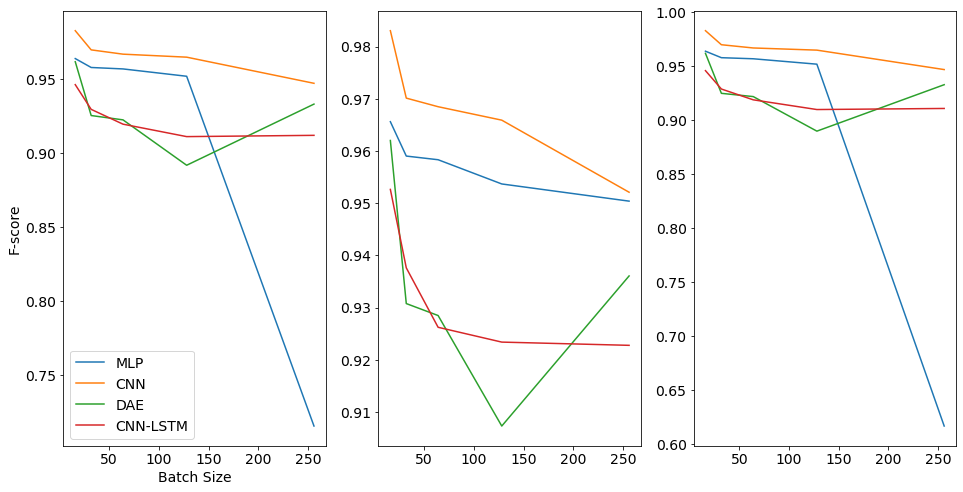

In [ ]:
#
# Plot change in F-score, precision and recall with different batch sizes
#
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,8))

batch_sizes = [16,32,64,128,256]
ax1.plot(batch_sizes,[(bs_metrics[i][:,3][0]) for i in range(len(bs_metrics))], label='MLP')
ax1.plot(batch_sizes,[(bs_metrics[i][:,3][1]) for i in range(len(bs_metrics))], label='CNN')
ax1.plot(batch_sizes,[(bs_metrics[i][:,3][2]) for i in range(len(bs_metrics))], label='DAE')
ax1.plot(batch_sizes,[(bs_metrics[i][:,3][3]) for i in range(len(bs_metrics))], label='CNN-LSTM')

ax2.plot(batch_sizes, [(bs_metrics[i][:,1][0]) for i in range(len(bs_metrics))], label='MLP')
ax2.plot(batch_sizes, [(bs_metrics[i][:,1][1]) for i in range(len(bs_metrics))], label='CNN')
ax2.plot(batch_sizes, [(bs_metrics[i][:,1][2]) for i in range(len(bs_metrics))], label='DAE')
ax2.plot(batch_sizes, [(bs_metrics[i][:,1][3]) for i in range(len(bs_metrics))], label='CNN-LSTM')

ax3.plot(batch_sizes, [(bs_metrics[i][:,2][0]) for i in range(len(bs_metrics))], label='MLP')
ax3.plot(batch_sizes, [(bs_metrics[i][:,2][1]) for i in range(len(bs_metrics))], label='CNN')
ax3.plot(batch_sizes, [(bs_metrics[i][:,2][2]) for i in range(len(bs_metrics))], label='DAE')
ax3.plot(batch_sizes, [(bs_metrics[i][:,2][3]) for i in range(len(bs_metrics))], label='CNN-LSTM')

ax1.set_ylabel('F-score')
ax1.set_xlabel('Batch Size')
ax1.legend()

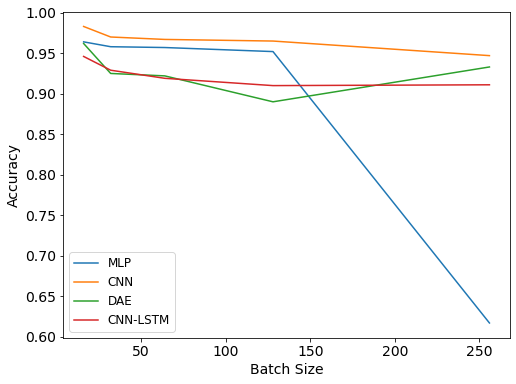

In [ ]:
#
# Plot accuracy
#

fig, ax = plt.subplots(figsize=(8,6))

batch_sizes = [16,32,64,128,256]
ax.plot(batch_sizes,[(bs_metrics[i][:,0][0]) for i in range(len(bs_metrics))], label='MLP')
ax.plot(batch_sizes,[(bs_metrics[i][:,0][1]) for i in range(len(bs_metrics))], label='CNN')
ax.plot(batch_sizes,[(bs_metrics[i][:,0][2]) for i in range(len(bs_metrics))], label='DAE')
ax.plot(batch_sizes,[(bs_metrics[i][:,0][3]) for i in range(len(bs_metrics))], label='CNN-LSTM')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Batch Size')
ax.legend(prop={'size':12})

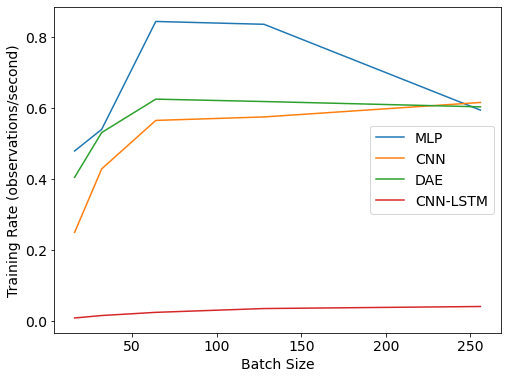

In [ ]:
#
# Plot change in training times as batch size increases (as CNN-LSTM time is much greater, plot reciprocal)
#
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(batch_sizes, 1/bs_times[:,0], label='MLP')
ax.plot(batch_sizes, 1/bs_times[:,1], label='CNN')
ax.plot(batch_sizes, 1/bs_times[:,2], label='DAE')
ax.plot(batch_sizes, 1/bs_times[:,3], label='CNN-LSTM')

ax.set_xlabel('Batch Size')
ax.set_ylabel('Training Rate (observations/second)')
ax.legend(prop={'size':14})

# Change loss function

In [ ]:
# Function to call to evaluate classifier's performance when using different loss functions
def lossFnEvaluate():
  loss_fns = ['mse', 'msle', 'categorical_crossentropy', 'mae'] # we have selected these as common loss functions
  loss_metrics = [] # hold results regarding predictions
  loss_times = [] # hold training times

  for n in loss_fns: # for each loss function
    # hold times
    timecount = []

    # Train each classifier and measure the training time
    start = timer()
    mlp_loss_model = MLP(train_data, train_labels, loss_fn=n, epochs=5)
    a = mlp_loss_model.perf(test_data, test_labels)
    end = timer()
    timecount.append(end-start)

    start = timer()
    cnn_loss_model = CNN(train_data, train_labels, loss_fn=n, epochs=5)
    b = cnn_loss_model.perf(test_data, test_labels)
    end = timer()
    timecount.append(end-start)

    start = timer()
    dae_loss_model = DAE(normal_train_data, normal_test_data, loss_fn=n, epochs=5)
    c = dae_loss_model.perf(test_data, test_labels)
    end = timer()
    timecount.append(end-start)

    start = timer()
    cnn_lstm_loss_model = CNN_LSTM(train_data, train_labels, loss_fn=n, epochs=5)
    d = cnn_lstm_loss_model.perf(test_data, test_labels)
    end = timer()
    timecount.append(end-start)

    loss_metrics.append([a,b,c,d])
    loss_times.append(timecount)

  return loss_metrics, loss_times

loss_metrics, loss_times = lossFnEvaluate()
loss_metrics = np.array(loss_metrics)
loss_times = np.array(loss_times)
loss_metrics

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[[0.959     , 0.96030308, 0.959     , 0.95913766],
        [0.98      , 0.98010227, 0.98      , 0.98001536],
        [0.907     , 0.91762646, 0.907     , 0.90820742],
        [0.919     , 0.92671721, 0.919     , 0.91984364]],

       [[0.961     , 0.96229188, 0.961     , 0.96113095],
        [0.56      , 1.        , 0.56      , 0.71794872],
        [0.925     , 0.92993101, 0.925     , 0.92557246],
        [0.946     , 0.95013182, 0.946     , 0.94637732]],

       [[0.961     , 0.96324448, 0.961     , 0.96118682],
        [0.982     , 0.98199935, 0.982     , 0.98199569],
        [0.56      , 1.        , 0.56      , 0.71794872],
        [0.922     , 0.92716753, 0.922     , 0.92261249]],

       [[0.56      , 1.        , 0.56      , 0.71794872],
        [0.957     , 0.95831429, 0.957     , 0.95714438],
        [0.957     , 0.95736071, 0.957     , 0.95706304],
        [0.911     , 0.91987273, 0.911     , 0.91201593]]])

In [ ]:
#
# Mean training time for each loss function (and standard dev)
#
print([np.mean(loss_times[i]) for i in range(len(loss_times))])
print([np.std(loss_times[i]) for i in range(len(loss_times))])
print('')
#
# Mean F-score for each loss function (and standard dev)
#
print([np.mean(loss_metrics[i][:,3]) for i in range(len(loss_metrics))])
print([np.std(loss_metrics[i][:,3]) for i in range(len(loss_metrics))])
print('')
#
# Mean precision for each loss function (and standard dev)
#
print([np.mean(loss_metrics[i][:,1]) for i in range(len(loss_metrics))])
print([np.std(loss_metrics[i][:,1]) for i in range(len(loss_metrics))])
print('')
#
# Mean recall for each loss function (and standard dev)
#
print([np.mean(loss_metrics[i][:,2]) for i in range(len(loss_metrics))])
print([np.std(loss_metrics[i][:,2]) for i in range(len(loss_metrics))])

[9.218917314000066, 9.047144173749984, 8.639662681000004, 8.824080152750014]
[12.547461038902188, 11.808995133526205, 11.661964482884802, 12.021400434809058]

[0.941801021658049, 0.8877573613231207, 0.8959359285677827, 0.8860430185559082]
[0.029032532980344784, 0.09884955711328637, 0.10494647133593803, 0.09877946875040801]

[0.9461872564935065, 0.960588676948052, 0.9681028409090909, 0.9588869318181819]
[0.025220461720048267, 0.025521520080684, 0.026971489038949806, 0.028350704555416724]

[0.94125, 0.8479999999999999, 0.8562500000000001, 0.84625]
[0.029515885553376142, 0.16676780264787322, 0.17238963860974937, 0.16633005591293473]


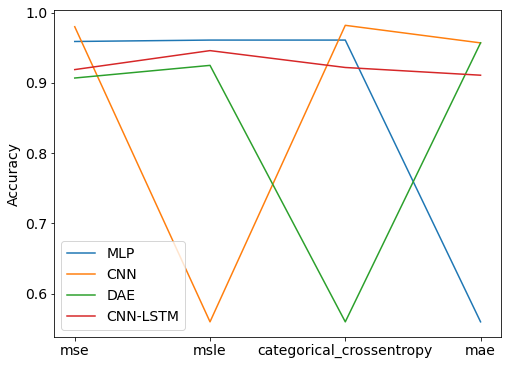

In [ ]:
#
# Plot accuracy
#
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(8,6))

loss_fns = ['mse', 'msle', 'categorical_crossentropy', 'mae']

ax.plot(loss_fns,[(loss_metrics[i][:,0][0]) for i in range(len(loss_metrics))], label='MLP')
ax.plot(loss_fns,[(loss_metrics[i][:,0][1]) for i in range(len(loss_metrics))], label='CNN')
ax.plot(loss_fns,[(loss_metrics[i][:,0][2]) for i in range(len(loss_metrics))], label='DAE')
ax.plot(loss_fns,[(loss_metrics[i][:,0][3]) for i in range(len(loss_metrics))], label='CNN-LSTM')

ax.set_ylabel('Accuracy')
ax.legend(prop={'size':14})

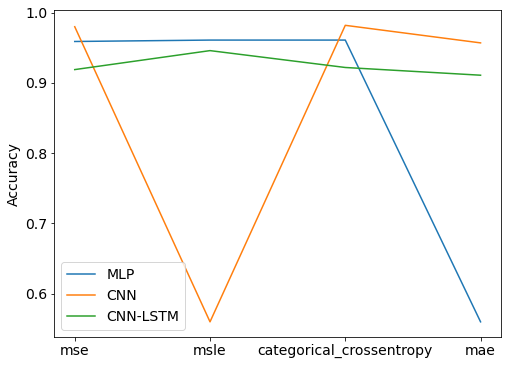

In [ ]:
#
# Plot accuracy for MLP, CNN, CNN-LSTM as DAE results can be anomalous
#

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(8,6))

loss_fns = ['mse', 'msle', 'categorical_crossentropy', 'mae']

ax.plot(loss_fns,[(loss_metrics[i][:,0][0]) for i in range(len(loss_metrics))], label='MLP')
ax.plot(loss_fns,[(loss_metrics[i][:,0][1]) for i in range(len(loss_metrics))], label='CNN')
#ax.plot(loss_fns,[(loss_metrics[i][:,0][2]) for i in range(len(loss_metrics))], label='DAE')
ax.plot(loss_fns,[(loss_metrics[i][:,0][3]) for i in range(len(loss_metrics))], label='CNN-LSTM')

ax.set_ylabel('Accuracy')
ax.legend(prop={'size':14})

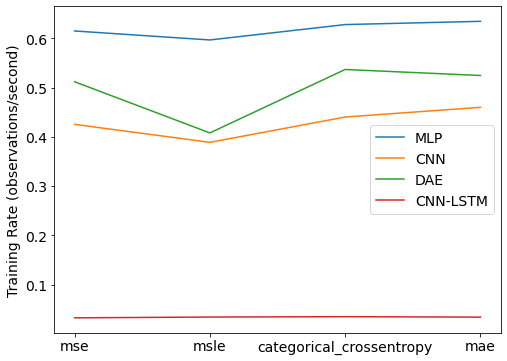

In [ ]:
#
# Plot training time for different loss functions
#

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(loss_fns, 1/loss_times[:,0], label='MLP')
ax.plot(loss_fns, 1/loss_times[:,1], label='CNN')
ax.plot(loss_fns, 1/loss_times[:,2], label='DAE')
plt.plot(loss_fns, 1/loss_times[:,3], label='CNN-LSTM')
ax.set_ylabel('Training Rate (observations/second)')
ax.legend()

# Training times of classifiers

In [ ]:
training_times

[2.8968702100000314, 3.582537359000014, 2.3003885389999823, 26.477779697000017]

Text(0.5, 0, 'Classifier')

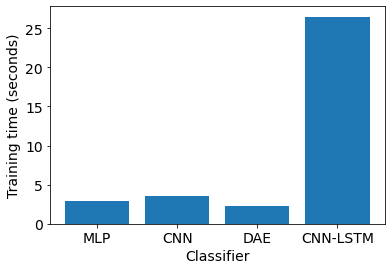

In [ ]:
plt.bar(['MLP', 'CNN', 'DAE', 'CNN-LSTM'], training_times)
plt.ylabel('Training time (seconds)')
plt.xlabel('Classifier')

# Aiming for maximum performance

In [ ]:
cnn_max = CNN(train_data, train_labels, epochs=25, batch_size=64)
cnn_max.perf(test_data, test_labels)

(0.986, 0.986237012987013, 0.986, 0.98601851286746)

In [ ]:
dae_max = DAE(normal_train_data, normal_test_data, latent=128, epochs=50, batch_size=32)
dae_max.perf(test_data, test_labels)

(0.928, 0.9363571428571429, 0.928, 0.9288036378668871)

In [ ]:
cnn_lstm_max = CNN_LSTM(train_data, train_labels, epochs=25, batch_size=32)
cnn_lstm_max.perf(test_data, test_labels)

(0.956, 0.9572178571428571, 0.956, 0.956140284700705)